# Flopy Tutorial 1

In [1]:
import os
import sys
import numpy as np
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil

In [2]:
workspace = os.path.join('tutorial-1')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

In [4]:
# Assign name and create modflow model object
modelname = 'tutorial1'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005', model_ws = workspace)

In [5]:
# Model domain and grid definition
Lx = 1000.
Ly = 1000.
ztop = 50.
zbot = 0
nlay = 1
nrow = 10
ncol = 10
delr = 100.446
delc = 101.100
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

In [6]:
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:], proj4_str = 'EPSG:31985',xul = 292147.853,
                                yul = 9105709.477)
flopy.export.shapefile_utils.model_attributes_to_shapefile('model.shp', mf, package_names = ['dis'])

wrote model.shp


In [7]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
#ibound[:, :, 0] = -1
#ibound[:, :, -1] = -1
strt = 50* np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 60.
strt[:, :, -1] = 50.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [8]:
#chd
spchd = {}
spchd[0] = [
    [0, 0, 0, 60, 60], 
    [0, 0, ncol-1, 50, 50]
]
for row in range (1, nrow):
    spchd[0].append ([0,row, 0, 60, 60 ])
    spchd[0].append ([0,row, ncol-1, 50, 50 ])

chd = flopy.modflow.ModflowChd(mf, stress_period_data=spchd)

In [9]:
# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10., chani = 0 ,ipakcb=53)

In [10]:
# Add OC package to the MODFLOW model
spd = {(0, 0): ['save head', #'print head', 'print budget', 'save budget'
               ]}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

In [11]:
# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf,hclose=1e-02, rclose=1e-02)

In [12]:
# Write the MODFLOW model input files
mf.write_input()
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following  executable to run the model: C:\modflow\Packages\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tutorial1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/01/21 16:17:00

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/01/21 16:17:00
 Elapsed run time:  0.009 Seconds

  Normal termination of simulation


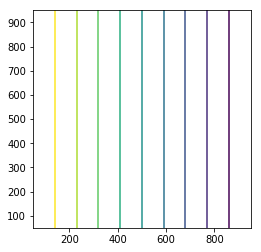

In [13]:
plt.subplot(1,1,1,aspect='equal')
hds = bf.HeadFile(modelname+'.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(1,10,1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
plt.show()

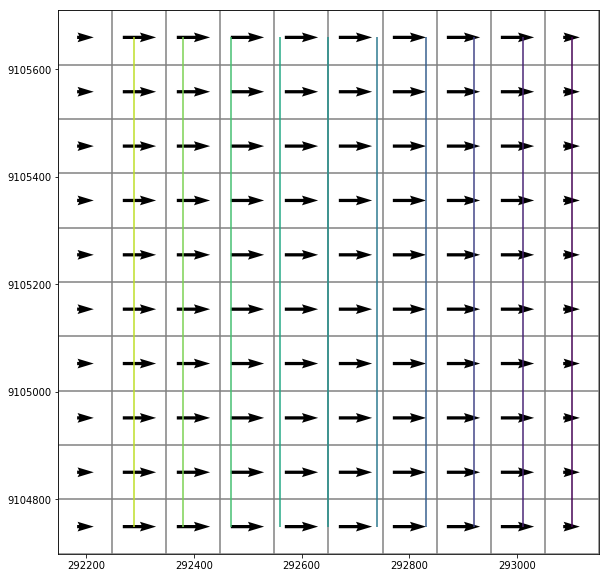

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hds = bf.HeadFile(modelname+'.hds')
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 11)

cbb = bf.CellBudgetFile(modelname+'.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=mf, layer=0)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=levels)
quiver = modelmap.plot_discharge(frf, fff, head=head)
plt.show()